#### What are the top crops of Saskatchewan?
#### Where are the top crops produced in Saskatchewan?
#### Which RM is a top producer? and what crops does it produces?

In [148]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sb
plt.rcParams['figure.figsize'] = (4, 4)

# ETL (extract, transform, load)

## load csv, shp file

In [167]:
#load into main df_csv
df_csv = pd.read_csv('rm_crop_yields_1938_2021.csv')

In [168]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25017 entries, 0 to 25016
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25017 non-null  int64  
 1   RM            25017 non-null  int64  
 2   Winter Wheat  3037 non-null   float64
 3   Canola        14008 non-null  float64
 4   Spring Wheat  24924 non-null  float64
 5   Mustard       4487 non-null   float64
 6   Durum         11581 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          23913 non-null  float64
 9   Lentils       5515 non-null   float64
 10  Peas          8134 non-null   float64
 11  Barley        24703 non-null  float64
 12  Fall Rye      15847 non-null  float64
 13  Canary Seed   3819 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          20934 non-null  float64
 17  Chickpeas     960 non-null    float64
dtypes: float64(16), int64(2)
m

In [169]:
df_csv.rename(columns={"Winter Wheat": "WinterWheat", "Spring Wheat": "SpringWheat","Fall Rye":"FallRye",\
             "Canary Seed":"CanarySeed","Spring Rye":"SpringRye","Tame Hay":"TameHay"},inplace=True)

In [170]:
#https://saskpulse.com
#https://www.rayglen.com/grain-conversion-calculator/
# (lbs/ac) -> Mustard (50 lbs/bu), Sunflower (30 lbs/bu), Lentils (60 lbs/bu), 
#             Canary Seeed (50 lbs/bu), Chickpeas (60lb/bu)

# Tame Hay (tons/ac)
# All the rest are bushel/acre (bu/ac)
df_csv['Mustard']=df_csv['Mustard']/50
df_csv['Sunflowers']=df_csv['Sunflowers']/30
df_csv['Lentils']=df_csv['Lentils']/60
df_csv['CanarySeed']=df_csv['CanarySeed']/50
df_csv['Chickpeas']=df_csv['Chickpeas']/60

#cannot find conversion for Tame Hay
df_csv.drop(['TameHay'],axis=1,inplace=True)

In [171]:
#load shp data
gdf = gpd.read_file('Rural Municipality.shp')

#drop columns that won't be using
gdf.drop(['PPID','EFFDT','EXPDT','FEATURECD','SHAPE_AREA','SHAPE_LEN'],axis=1,inplace=True)

#rename column to match with main df
gdf.rename(columns=
{   'RMNO': 'RM',
    'RMNM': 'Municipality'
}, inplace=True)

#match data type between df_csv and gdf
gdf['RM']=gdf['RM'].astype('int')
gdf['Municipality']=gdf['Municipality'].astype('string')


In [172]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   RM            298 non-null    int64   
 1   Municipality  298 non-null    string  
 2   geometry      298 non-null    geometry
dtypes: geometry(1), int64(1), string(1)
memory usage: 7.1 KB


# EDA (Extrapolatory Data Analysis)

#### check for unique values

In [173]:
gdf['RM'].unique()
gdf['RM'].nunique()
#298 unique RM

298

#### check for duplicated values

In [174]:
gdf.duplicated().sum()

0

In [175]:
df_describe = df_csv.describe().copy()
df_describe
# Total of 25017 rows
# Year from 1938 to 2021 ~ 84 years
# 299 RM from 1 to 622 
# Spring Wheat, Barley and Oats have the most rows -> more complete data?
# Oats, Winter Wheat, Barley has the most mean -> most yield
# Tame Hay, Spring Rye, Flax have the least mean -> least yield

,Year,RM,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
count,25017.000000,25017.000000,3037.00000,14008.000000,24924.000000,4487.000000,11581.000000,946.000000,23913.000000,5515.000000,8134.000000,24703.000000,15847.000000,3819.000000,805.000000,20934.000000,960.000000
mean,1979.385938,248.957509,38.24350,24.146796,25.778733,16.883719,29.024429,23.087664,47.104433,19.529647,30.971982,38.022104,21.225298,19.902804,7.575776,14.287663,23.467677
std,24.221744,148.829628,12.20715,9.209177,11.153028,5.514007,9.829962,18.525887,21.775369,6.815627,10.223101,16.610425,10.101176,7.084164,12.473814,7.082308,9.660584
min,1938.000000,1.000000,3.00000,0.000000,0.000000,0.712000,0.000000,0.000000,0.000000,0.766667,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.516667
25%,1958.000000,124.000000,30.00000,18.000000,19.000000,13.270000,23.000000,0.000000,33.000000,15.000000,24.300000,26.000000,15.000000,15.140000,0.000000,9.000000,16.666667
50%,1979.000000,247.000000,38.00000,23.000000,25.600000,16.940000,28.200000,26.350000,46.000000,19.433333,31.000000,37.900000,20.000000,20.000000,0.000000,14.000000,22.941667
75%,2000.000000,370.000000,45.50000,29.200000,31.800000,20.018900,34.300000,36.666667,59.000000,23.983333,37.900000,48.750000,26.300000,24.000000,20.000000,19.200000,29.704167
max,2021.000000,622.000000,90.00000,59.500000,198.000000,50.000000,85.370000,80.000000,165.100000,56.850000,86.800000,105.940000,108.000000,54.540000,46.500000,110.000000,90.000000


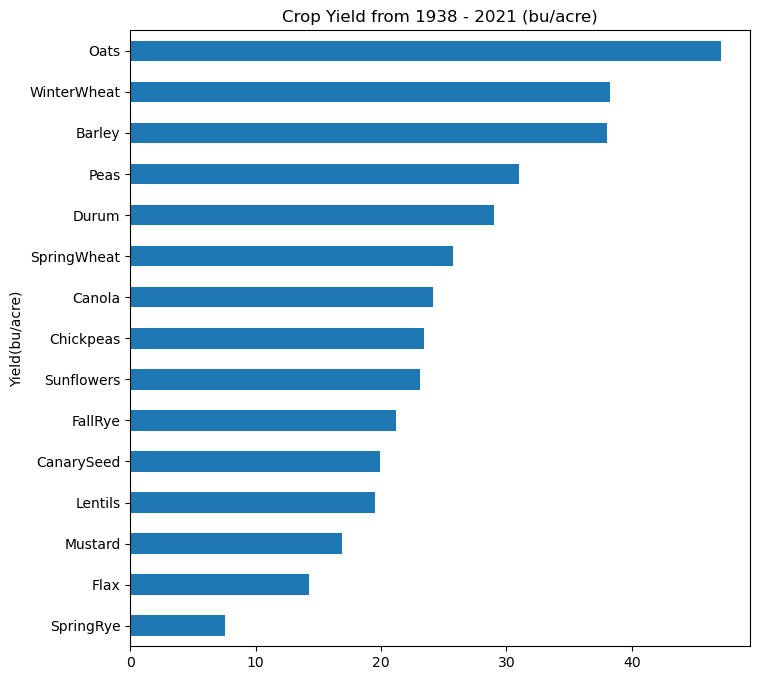

In [178]:
fig=df_describe.iloc[1, 2:17].sort_values(axis=0).plot(kind='barh',ylabel ='Yield(bu/acre)', figsize=(8,8),title='Crop Yield from 1938 - 2021 (bu/acre)').get_figure()
fig.savefig('Crop Yield 1938 to 2021.jpg')

In [ ]:
#count unique RM
df_csv['RM'].unique()
df_csv['RM'].nunique()

In [ ]:
#check for duplicated rows
df_csv.duplicated().sum()

In [ ]:
#check how many records there are each year
#-->not all have data for all years
temp_df= df_csv.groupby('Year').count()['RM']
temp_df = temp_df[temp_df!=299]
temp_df

In [ ]:
#check for RM with less than 84 years of data
temp_df= df_csv.groupby('RM').count()['Year']
temp_df = temp_df[temp_df!=84]
temp_df

In [ ]:
#Municipality with less than 84 years of data

pd.merge(temp_df,gdf,on='RM')

In [ ]:
#check for RM not in geodata

temp_df= df_csv.groupby('RM').count().index
temp_df = temp_df[~temp_df.isin(gdf['RM'])]
temp_df

#278 Kutawa, Prairie No. 408, Greenfield No. 529

In [ ]:
#check for geodata RM not in main data set

temp_df= df_csv.groupby('RM').count().index
temp_gdf = gdf[~gdf['RM'].isin(temp_df)]
temp_gdf

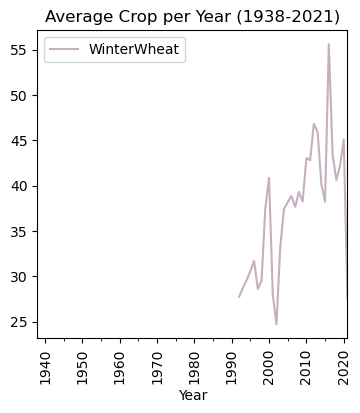

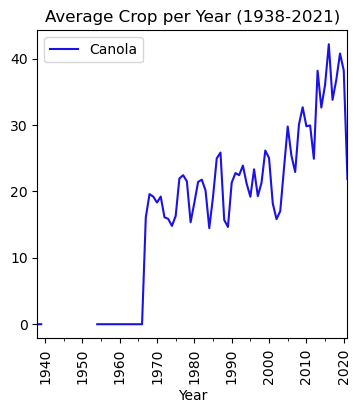

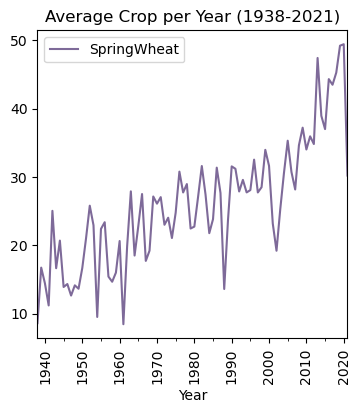

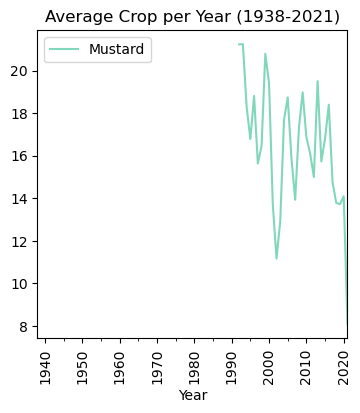

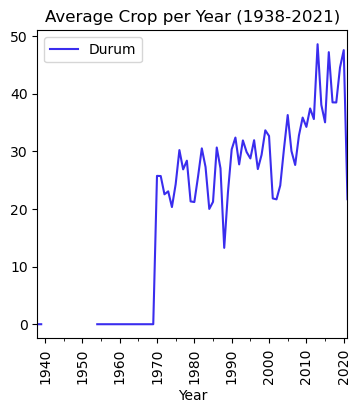

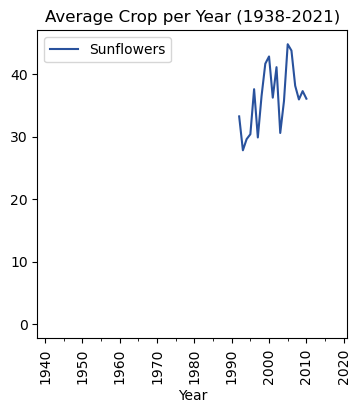

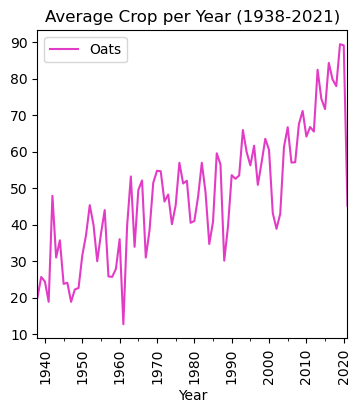

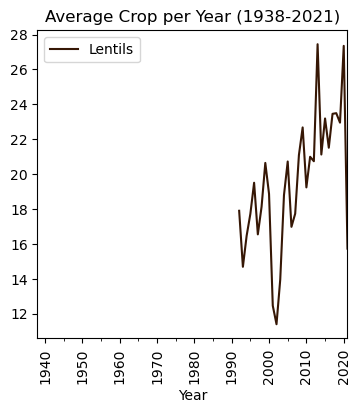

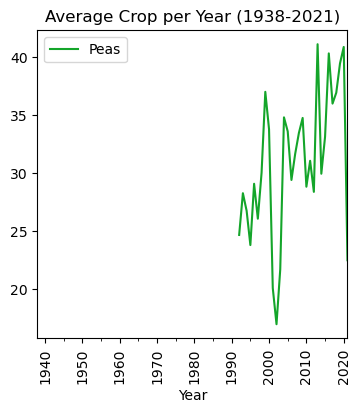

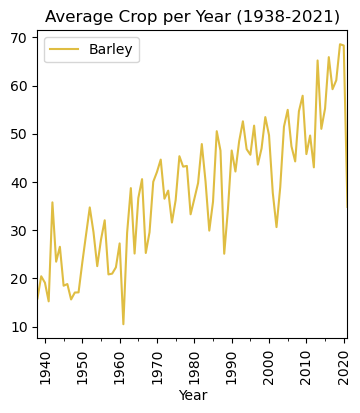

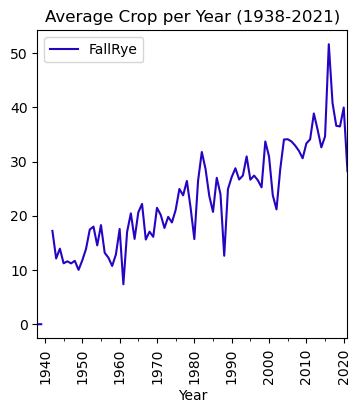

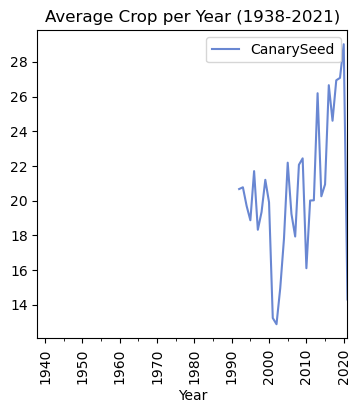

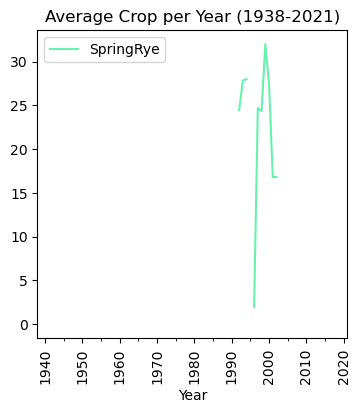

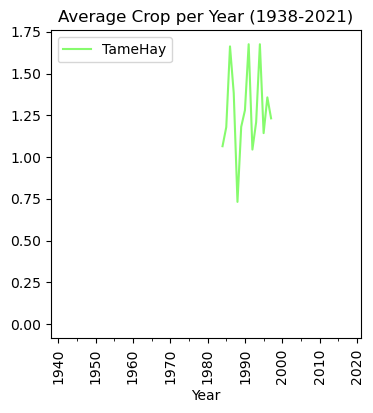

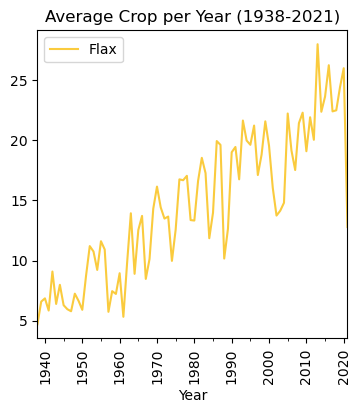

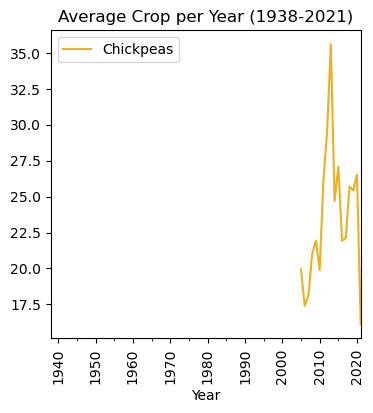

In [161]:

#df_csv.iloc[:,2:18].plot(x=df_csv.index, subplots=True, layout=(4,5))
temp_df= df_csv.copy()
temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
temp_df= temp_df.groupby('Year').mean().copy()
temp_df.drop(['RM'],axis=1,inplace=True)

for i in temp_df.columns:
    temp_df[i].plot(title='Average Crop per Year (1938-2021)',color=np.random.random(3))
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.savefig(i+'.jpg')
    plt.show()

# Feature Selection

In [ ]:
sb.heatmap(
    df_csv.corr(),
    annot=True)

#Strong correlation between Canola and Spring Wheat, Durum, Oats, Peas, Barley, Flax
#Strong correlation between Spring Wheat and Barley, Canola, Durun, Oats, Flax
#Strong correlation between Durum and Spring Wheat, Barley, Flax
#Strong correlation between Sunflower and Tame Hay
#Strong correlation between Oats and Spring Wheat, Durumn, Barley, Flax
#Strong correlation between Peas and Canola, Spring Wheat, Barley
#Strong correlation between Barley and Oats, Canola, Spring Wheat, Barley, Fall Rye, Flax
#Strong correlation between Fall Rye and Spring Wheat, Barley, Flax
#Strong correlation between Tame Hay and Sunflowers
#Flax and Spring Wheat, Oats, Barley, Canola, Durum

In [ ]:
df_csv.iloc[:,2:18].isna().sum().plot(kind='bar',ylabel='Count of missing values (1938-2021)',figsize=(6,6))

In [ ]:
#df_csv[df_csv['Year']>=2011].iloc[:,2:18].isna().sum().plot(kind='bar',ylabel='Count of missing values (2011-2021)',figsize=(6,6))



# K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

def call_ElbowMethod(df_meanstd):

# Define the features to be used for clustering
    X = df_meanstd[['MeanYield', 'StdYield']]

# Elbow method to determine the optimal number of clusters
    sse = []
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    
# Plot the elbow graph
    plt.plot(range(1, 12), sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.show()
    
    return X

In [ ]:
def call_KMeans(kcluster,X):

# Fit the KMeans model with the optimal number of clusters
    kmeans = KMeans(n_clusters=kcluster)
    kmeans.fit(X)

# Predict the cluster labels for each data point
    labels = kmeans.predict(X)

# Plot the data points and cluster centers
    plt.scatter(X['MeanYield'], X['StdYield'], c=labels)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='r')
    plt.xlabel('MeanYield')
    plt.ylabel('StdYield')
    plt.show()
    
    return labels

In [ ]:
def showClusterMap(kcluster,croptype):

    m=pd.merge(
        gdf[['RM', 'Municipality', 'geometry']],
        df_ms,
        on='RM'
        ).explore(
        column='Labels', # column you want to visualize
        cmap='YlGn', # color on the map
        k=kcluster, # number of colors. We have 3 clusters
        scheme='naturalbreaks', #How your legened will look like
        tiles='Stamen Terrain', # map background type
        tooltip=['Municipality', 'MeanYield'] # what to show when you hover around your mouse
    )
    m.save("Clustering_"+croptype+".html")

## Clustering Spring Wheat 

In [ ]:
new_df = df_csv[['Year','RM','SpringWheat']].copy()
new_df

In [ ]:
new_df.isna().sum()

In [ ]:
new_df[new_df['SpringWheat'].isna()].groupby('RM').count()

In [ ]:
new_df[new_df['SpringWheat'].isna()].groupby('Year').count()

In [ ]:
temp_df = new_df[new_df['RM']==555]
temp_df[temp_df['SpringWheat'].isna()]

In [ ]:
gdf[gdf['RM']==555]

In [ ]:
df_mean=new_df.groupby(['RM'])['SpringWheat'].mean()\
    .to_frame()

In [ ]:
df_std=new_df.groupby(['RM'])['SpringWheat'].std()\
    .to_frame()

In [ ]:
df_ms=pd.merge(
    df_mean.rename(columns={'SpringWheat': 'MeanYield'}),
    df_std.rename(columns={'SpringWheat': 'StdYield'}),
    on='RM'
)

In [ ]:
cluster_X = call_ElbowMethod(df_ms)

In [ ]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [ ]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

In [ ]:
df_ms.replace(to_replace={
    2:1,
    1:2}, inplace=True
)

In [ ]:
showClusterMap(3,'SpringWheat')

## Clustering Barley

In [ ]:
new_df = df_csv[['Year','RM','Barley']].copy()
new_df

In [ ]:
new_df.isna().sum()

In [ ]:
new_df[new_df['Barley'].isna()].groupby('RM').count()

In [ ]:
new_df[new_df['Barley'].isna()].groupby('Year').count()

In [ ]:
df_mean=new_df.groupby(['RM'])['Barley'].mean()\
    .to_frame()

In [ ]:
df_std=new_df.groupby(['RM'])['Barley'].std()\
    .to_frame()

In [ ]:
df_ms=pd.merge(
    df_mean.rename(columns={'Barley': 'MeanYield'}),
    df_std.rename(columns={'Barley': 'StdYield'}),
    on='RM'
)

In [ ]:
cluster_X = call_ElbowMethod(df_ms)

In [ ]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [ ]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

In [ ]:
df_ms.replace(to_replace={
    2:1,
    1:2}, inplace=True
)

In [ ]:
showClusterMap(3,'Barley')

## Clustering Oats

In [ ]:
new_df = df_csv[['Year','RM','Oats']].copy()
new_df

In [ ]:
new_df.isna().sum()

In [ ]:
new_df[new_df['Oats'].isna()].groupby('RM').count()

In [ ]:
new_df[new_df['Oats'].isna()].groupby('Year').count()

In [ ]:
df_mean=new_df.groupby(['RM'])['Oats'].mean()\
    .to_frame()

In [ ]:
df_std=new_df.groupby(['RM'])['Oats'].std()\
    .to_frame()

In [ ]:
df_ms=pd.merge(
    df_mean.rename(columns={'Oats': 'MeanYield'}),
    df_std.rename(columns={'Oats': 'StdYield'}),
    on='RM'
)

In [ ]:
cluster_X = call_ElbowMethod(df_ms)

In [ ]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [ ]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

In [ ]:
#df_ms.replace(to_replace={
#    1:2,
#    0:1,
#    2:0}, inplace=True
#)

In [ ]:
showClusterMap(3,'Oats')

## Clustering Flax

In [144]:
new_df = df_csv[['Year','RM','Flax']].copy()

In [145]:
new_df.isna().sum()

Year       0
RM         0
Flax    4083
dtype: int64

In [146]:
new_df[new_df['Flax'].isna()].groupby('RM').count()

,Year,Flax
RM,,
1,4,0
2,2,0
4,1,0
5,1,0
8,3,0
...,...,...
529,53,0
555,74,0
561,77,0


In [147]:
new_df[new_df['Flax'].isna()].groupby('Year').count()

,RM,Flax
Year,,
1938,105,0
1939,60,0
1940,58,0
1941,15,0
1942,14,0
...,...,...
2017,95,0
2018,109,0
2019,92,0


In [134]:
new_df[new_df['Year']>=2001].isna().sum()

Year       0
RM         0
Flax    1631
dtype: int64

In [135]:
new_df[new_df['Year']>=2001]

,Year,RM,Flax
63,2001,1,15.7
64,2002,1,12.2
65,2003,1,9.3
66,2004,1,20.9
67,2005,1,13.4
...,...,...,...
25012,2017,622,NaN
25013,2018,622,NaN
25014,2019,622,NaN
25015,2020,622,NaN


In [143]:
temp_df = new_df[new_df['RM']==622]
temp_df[temp_df['Flax'].notna()]

,Year,RM,Flax
24933,1938,622,0.0
24934,1939,622,0.0
24951,1956,622,7.0
24953,1958,622,8.0
24968,1973,622,10.0


## Clustering Canola

In [ ]:
new_df = df_csv[['Year','RM','Canola']].copy()

In [ ]:
new_df.isna().sum()

In [ ]:
new_df = new_df[new_df['Year']>=2001]

In [ ]:
new_df.isna().sum()

In [ ]:
new_df.count()

In [ ]:
new_df[new_df['Canola'].isna()].groupby('RM').count()

In [ ]:
new_df[new_df['Canola'].isna()].groupby('Year').count()

In [ ]:
df_mean=new_df.groupby(['RM'])['Canola'].mean()\
    .to_frame()

In [ ]:
df_std=new_df.groupby(['RM'])['Canola'].std()\
    .to_frame()

In [ ]:
df_ms=pd.merge(
    df_mean.rename(columns={'Canola': 'MeanYield'}),
    df_std.rename(columns={'Canola': 'StdYield'}),
    on='RM'
)

In [ ]:
cluster_X = call_ElbowMethod(df_ms)

In [ ]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [ ]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

In [ ]:
df_ms.replace(to_replace={
    1:2,
    0:1,
    2:0}, inplace=True
)

In [ ]:
showClusterMap(3,'Canola')